Data from:
Teorell, Jan, Stefan Dahlberg, Sören Holmberg, Bo Rothstein, Natalia Alvarado Pachon and Richard Svensson. 2019. The Quality of Government Standard Dataset, version Jan19. University of Gothenburg: The Quality of Government Institute, http://www.qog.pol.gu.se doi:10.18157/qogstdjan19

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.discrete.discrete_model as sm
import statsmodels
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
pd.options.display.max_columns=999
df = pd.read_csv('Untitled spreadsheet - Sheet1.csv')
df = df.drop('Unnamed: 3', 1)
df = df.dropna()
borders = []
for i in df['Borders']:
    borders.append(i.split('/'))
within = []
for i in df['Within']:
    within.append(i.split('/'))
df['Borders'] = borders
df['Within'] = within
df2 = df.drop(0)
borders = []
for n in df.index:
    x = df.loc[n][0]
    for i in df.loc[n][-1]:
        borders.append([x,i])
borders = pd.DataFrame(borders)
borders = borders.drop([0,1]).reset_index().drop('index',1)
# quality of life indicators
cpi = pd.read_csv('cpi.csv')
cpi = cpi[['Country','2015 cpi']]
cpi = cpi.replace('-',np.nan)
cpi['2015 cpi'] = [float(x) for x in cpi['2015 cpi']]
edbi = pd.read_csv('edbiscores.csv')
homicide = pd.read_csv('homicide.csv')
pfi = pd.read_csv('pfi.csv')[['Country','Score']]
pfi.columns = ['Country','2018 pfi']
pfi['2018 pfi'] = [float(x) for x in pfi['2018 pfi']]
homicide.columns = ['Country','Region','Subregion','Homicide Rate','Homicide County','Year','Source']
qol = pd.merge(cpi,pfi,on='Country')
qol = pd.merge(qol,edbi,on='Country')
qol = pd.merge(qol, homicide, on='Country')
qol['score'] = qol['2015 cpi'] / qol['2018 pfi'] * qol['DB 2019']
qol.head()
#GDP and Population
data = pd.read_csv('world_indicators_all_years.csv')
data = data[data['Time'] == '2016']
data = data.replace('Iran, Islamic Rep.','Iran').replace('Korea, Dem. People’s Rep.',"Democratic People's Republic of Korea").replace('Lao PDR','Laos').replace('Korea, Rep.','Korea,South').replace('Macedonia, FYR','Macedonia').replace('Myanmar','Myanmar (Burma)').replace('Russian Federation','Russia').replace('Slovak Republic','Slovakia').replace('Syrian Arab Republic','Syria').replace('Venezuela, RB','Venezuela').replace('Yemen, Rep.','Yemen')
data1 = data[['Country Name', 'Population, total [SP.POP.TOTL]','Population growth (annual %) [SP.POP.GROW]','GDP (current US$) [NY.GDP.MKTP.CD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']]
data1 = data1.replace('..',np.nan)
for x in [*data1.columns][1:]:
    data1[x] = [float(i) for i in data1[x]]
data1['Population, total [SP.POP.TOTL]'] = [float(n) for n in data1['Population, total [SP.POP.TOTL]']]
data1 = pd.merge(qol,data1,left_on='Country',right_on='Country Name')
#treaties
schengen = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Iceland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta','Netherlands','Monaco','Norway','Poland','Portugal','San Marino','Slovakia','Slovenia','Spain','Sweden','Switzerland','Vatican City']
common = ['Ireland','United Kingdom']
unionstate = ['Russia','Belarus']
peaceandfriendship = ['India','Bhutan','Nepal']
ca4 = ['El Salvador','Honduras','Guatemala','Nicaragua']
tasman = ['Australia','New Zealand']
andean = ['Bolivia','Ecuador','Colombia','Peru']
caricom = ['Antigua and Barbuda','Barbados', 'Belize', 'Dominica', 'Grenada','Guyana','Jamaica','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Suriname','Trinidad and Tobago']
gcc = ['Saudi Arabia','Oman','Kuwait','United Arab Emirates','Bahrain']
eac = ['Kenya','Tanzania','Uganda','South Sudan','Rwanda','Burundi']
table = [schengen+common+unionstate+peaceandfriendship+ca4+tasman+andean+caricom+gcc+eac,['Schengen'] * len(schengen) + ['Common'] * len(common) + ['Union State'] * len(unionstate) + ['Peace and Friendship'] * len(peaceandfriendship) + ['Central America 4'] * len(ca4) + ['Trans-Tasman Agreement'] * len(tasman) + ['Andean Community'] * len(andean) + len(caricom) * ['Caricom'] + len(gcc) * ['Gulf Cooperation Council'] + ['East African Community'] * len(eac)]
treaties = pd.DataFrame(table).transpose()
treaties.columns = ['Country','Treaty']
notreaty = pd.DataFrame([*set(treaties['Country'])^set(data1['Country Name'])])
notreaty['Treaty'] = None
notreaty.columns = ['Country','Treaty']
treaties = pd.concat([notreaty,treaties])
data1 = pd.merge(data1,treaties)
#bring it all together
test1 = pd.merge(borders,data1,left_on=0,right_on='Country Name')
test1.columns = ['Country 1','Country 2','C','2015 cpi', '2018 pfi', 'DB 2018',
       'DB 2019', 'Region', 'Subregion', 'Homicide Rate', 'Homicide County',
       'Year', 'Source', 'score', 'Country Name','Population 1','Population growth 1','GDP 1','GDP per capita 1','Treaty 1']
test1['Country 2'] = [s.rstrip(" ").lstrip(' ') for s in test1['Country 2']]
test2 = pd.merge(test1,data1,left_on='Country 2',right_on='Country Name')
#More statistics
test2.columns = ['Country 1', 'Country 2', 'C', '2015 cpi_x', '2018 pfi_x', 'DB 2018_x', 'DB 2019_x', 'Region_x', 'Subregion_x',
       'Homicide Rate_x', 'Homicide County_x', 'Year_x', 'Source_x', 'score_x',
       'Country Name_x', 'Population 1', 'Population growth 1', 'GDP 1',
       'GDP per capita 1','Treaty 1', 'Country', '2015 cpi_y', '2018 pfi_y', 'DB 2018_y', 'DB 2019_y', 'Region_y', 'Subregion_y',
       'Homicide Rate_y', 'Homicide County_y', 'Year_y', 'Source_y', 'score_y',
       'Country Name_y', 'Population 2',
       'Population growth 2','GDP 2','GDP per capita 2','Treaty 2']
test2['Population difference'] = test2['Population 1'] / test2['Population 2']
test2['Population growth difference'] = test2['Population growth 1']/ test2['Population growth 2']
test2['GDP difference'] = test2['GDP 1'] / test2['GDP 2']
test2['GDP per capita difference'] = test2['GDP per capita 1'] / test2['GDP per capita 2']
df1 = test2
test2['Population difference'] = [1/x if x > 1 else x for x in test2['Population difference'] ]
test2['Population growth difference'] = [1/x if x > 1 else x for x in test2['Population growth difference']]
test2['GDP difference'] = [1/x if x > 1 else x for x in test2['GDP difference']]
test2['GDP per capita difference'] = [1/x if x > 1 else x for x in test2['GDP per capita difference']]
test2 = pd.merge(test2,df2, left_on='Country 1', right_on='Name of country').drop('Borders',1)
test2['GDP product'] = test2['GDP 1'] *test2['GDP 2']
test2['GDP per capita in both'] = (test2['GDP 1'] + test2['GDP 2']) / (test2['Population 1'] + test2['Population 2'])
test2 = test2.drop_duplicates('GDP product').reset_index()
df1['cpi difference'] = df1['2015 cpi_x'] / df1['2015 cpi_y']
#df1['cpi difference'] = [1/x if x > 1 for x in df1['cpi difference'] else x]
df1['cpi difference'] = [1/x if x > 1 else x for x in df1['cpi difference']]
df1['db difference'] = df1['DB 2019_x'] / df1['DB 2019_y']
df1['db difference'] = [1/x if x > 1 else x for x in df1['db difference']]
df1['pfi difference'] = df1['2018 pfi_x'] / df1['2018 pfi_y']
df1['pfi difference'] = [1/x if x > 1 else x for x in df1['pfi difference']]
df1['homicide difference'] = df1['Homicide Rate_x'] / df1['Homicide Rate_y']
df1['homicide difference'] = [1/x if x > 1 else x for x in df1['homicide difference']]
df1['Country Similarity'] = (df1['cpi difference']+df1['db difference']+df1['pfi difference']+df1['homicide difference']) /4
df1['average cpi'] = df1[['2015 cpi_x','2015 cpi_y']].mean(axis=1)
df1['average db'] = df1[['DB 2019_x','DB 2019_y']].mean(axis=1)
df1['average pfi'] = df1[['2018 pfi_x','2018 pfi_y']].mean(axis=1)
df1['average score']=df1['score_x']+df1['score_y']
df1['average homicide'] = df1[['Homicide Rate_x','Homicide Rate_y']].mean(axis=1)
df1['Border Status'] = np.where(df1['Treaty 1'] == df1['Treaty 2'], 'Open', 'Closed')
df1['Combined Population'] = df1['Population 1'] + df1['Population 2']
df1['viability'] = df1['average cpi'] * df1['average db'] / (df1['average pfi'] * df1['average homicide'])
df1['viability2'] = df1['average cpi'] * df1['average db'] * df1['GDP per capita difference'] / (df1['average pfi'] * df1['average homicide'])
df1 = df1.drop_duplicates('Combined Population').sort_values('viability', ascending = False).reset_index().drop('index',1)
df1.head()

Country 1    Country 2            C  2015 cpi_x  2018 pfi_x  DB 2018_x  \
0       Sweden       Norway       Sweden        89.0        8.31      81.27   
1      Finland       Norway      Finland        90.0       10.26      80.30   
2      Austria  Switzerland      Austria        76.0       14.04      78.54   
3      Finland       Sweden      Finland        90.0       10.26      80.30   
4  Netherlands      Germany  Netherlands        87.0       10.01      76.03   

   DB 2019_x Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  \
0      81.27   Europe  Northern Europe             1.08              106.0   
1      80.35   Europe  Northern Europe             1.42               78.0   
2      78.57   Europe   Western Europe             0.66               57.0   
3      80.35   Europe  Northern Europe             1.42               78.0   
4      76.04   Europe   Western Europe             0.55               94.0   

   Year_x       Source_x     score_x Country Name_x  Population 1  \
0  2016.0       NCCP/CTS  870.400722         Sweden     9903122.0   
1  2016.0      UNSDC/CTS  704.824561        Finland     5495096.0   
2  2016.0  EUR/UNSDC/CTS  425.307692        Austria     8747358.0   
3  2016.0      UNSDC/CTS  704.824561        Finland     5495096.0   
4  2016.0        NSO/CTS  660.887113    Netherlands    17018408.0   

   Population growth 1         GDP 1  GDP per capita 1  Treaty 1      Country  \
0             1.055074  5.144600e+11      51949.271432  Schengen       Norway   
1             0.283654  2.385029e+11      43402.863264  Schengen       Norway   
2             1.314007  3.908000e+11      44676.345835  Schengen  Switzerland   
3             0.283654  2.385029e+11      43402.863264  Schengen       Sweden   
4             0.462244  7.772275e+11      45669.814802  Schengen      Germany   

   2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y Region_y      Subregion_y  \
0        87.0        7.63      82.70      82.95   Europe  Northern Europe   
1        87.0        7.63      82.70      82.95   Europe  Northern Europe   
2        86.0       11.27      75.68      75.69   Europe   Western Europe   
3        89.0        8.31      81.27      81.27   Europe  Northern Europe   
4        81.0       14.39      78.90      78.90   Europe   Western Europe   

   Homicide Rate_y  Homicide County_y  Year_y       Source_y     score_y  \
0             0.51               27.0  2016.0    SDG/EUR/CTS  945.825688   
1             0.51               27.0  2016.0    SDG/EUR/CTS  945.825688   
2             0.54               45.0  2016.0  UNSDC/EUR/CTS  577.581189   
3             1.08              106.0  2016.0       NCCP/CTS  870.400722   
4             1.18              963.0  2016.0      UNSDC/CTS  444.120917   

  Country Name_y  Population 2  Population growth 2         GDP 2  \
0         Norway     5232929.0             0.850590  3.710762e+11   
1         Norway     5232929.0             0.850590  3.710762e+11   
2    Switzerland     8372098.0             1.077221  6.688513e+11   
3         Sweden     9903122.0             1.055074  5.144600e+11   
4        Germany    82667685.0             1.193867  3.477796e+12   

   GDP per capita 2  Treaty 2  Population difference  \
0      70911.757159  Schengen               0.528412   
1      70911.757159  Schengen               0.952291   
2      79890.524005  Schengen               0.957100   
3      51949.271432  Schengen               0.554885   
4      42069.597987  Schengen               0.205865   

   Population growth difference  GDP difference  GDP per capita difference  \
0                      0.806190        0.721293                   0.732590   
1                      0.333480        0.642733                   0.612069   
2                      0.819799        0.584285                   0.559220   
3                      0.268848        0.463599                   0.835486   
4                      0.387182        0.223483                   0.921169   

   cpi difference 

In [3]:
qog=pd.read_csv('qog_std_cs_jan19.csv')

In [4]:
qog

ccode        cname ccodealp  ccodecow  ccodewb        version  aid_cpnc  \
0        4  Afghanistan      AFG     700.0      4.0  QoGStdCSJan19       NaN   
1        8      Albania      ALB     339.0      8.0  QoGStdCSJan19       NaN   
2       12      Algeria      DZA     615.0     12.0  QoGStdCSJan19       NaN   
3       20      Andorra      AND     232.0     20.0  QoGStdCSJan19       NaN   
4       24       Angola      AGO     540.0     24.0  QoGStdCSJan19       NaN   
..     ...          ...      ...       ...      ...            ...       ...   
189    860   Uzbekistan      UZB     704.0    860.0  QoGStdCSJan19       NaN   
190    862    Venezuela      VEN     101.0    862.0  QoGStdCSJan19       NaN   
191    882        Samoa      WSM     990.0    882.0  QoGStdCSJan19       NaN   
192    887        Yemen      YEM     679.0    887.0  QoGStdCSJan19       NaN   
193    894       Zambia      ZMB     551.0    894.0  QoGStdCSJan19       NaN   

     aid_cpsc  aid_crnc  aid_crnio      aid_crsc     aid_crsio    aii_acc  \
0         NaN      29.0       13.0  5.300439e+09  1.354277e+09        NaN   
1         NaN      26.0       13.0  2.526468e+08  5.110954e+08        NaN   
2         NaN      21.0        6.0  4.814314e+08  8.241578e+07  41.666668   
3         NaN       NaN        NaN           NaN           NaN        NaN   
4         NaN      22.0       13.0  1.714512e+08  2.686289e+08  44.444443   
..        ...       ...        ...           ...           ...        ...   
189       NaN      21.0       16.0  7.295572e+08  1.474747e+09        NaN   
190       NaN      20.0        6.0  2.990472e+07  1.719696e+07        NaN   
191       NaN      10.0        7.0  7.095205e+07  8.198756e+07        NaN   
192       NaN      26.0       16.0  6.643827e+08  7.676985e+08        NaN   
193       NaN      22.0       18.0  9.508410e+08  5.324820e+08  55.555557   

       aii_aio  aii_cilser  aii_elec   aii_pubm  aii_q01  aii_q02  aii_q03  \
0          NaN         NaN       NaN        NaN      NaN      NaN      NaN   
1          NaN         NaN       NaN        NaN      NaN      NaN      NaN   
2    15.789474   41.666668      20.0  29.545454      0.0      0.0      0.0   
3          NaN         NaN       NaN        NaN      NaN      NaN      NaN   
4    26.315790   16.666666      25.0  25.000000    100.0      0.0      0.0   
..         ...         ...       ...        ...      ...      ...      ...   
189        NaN         NaN       NaN        NaN      NaN      NaN      NaN   
190        NaN         NaN       NaN        NaN      NaN      NaN      NaN   
191        NaN         NaN       NaN        NaN      NaN      NaN      NaN   
192        NaN         NaN       NaN        NaN      NaN      NaN      NaN   
193  31.578947   45.833332      40.0  72.727272      0.0     50.0     25.0   

     aii_q04  aii_q05  aii_q06  aii_q07  aii_q08  aii_q09  aii_q10  aii_q11  \
0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       50.0    100.0      0.0      0.0     25.0      0.0    100.0      0.0   
3        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4       25.0    100.0    100.0      0.0     25.0      0.0    100.0    100.0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
189      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
190      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
191      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
192      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
193    100.0    100.0      0.0     75.0     75.0     50.0    100.0    100.0   

     aii_q12  aii_q13  aii_q14  aii_q15  aii_q16  aii_q17  aii_q18  aii_q19  \
0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN

In [5]:
df1=pd.merge(pd.merge(df1,qog,left_on='Country 1',right_on='cname'),qog,left_on='Country 2',right_on='cname')

In [6]:
df1.shape

(185, 4022)

In [7]:
df1=df1.dropna(axis=1)

In [8]:
df1['Status'] = df1['Border Status'].replace('Open',1).replace('Closed',0)
df1.head()

Country 1    Country 2        C  2018 pfi_x  DB 2018_x  DB 2019_x Region_x  \
0    Sweden       Norway   Sweden        8.31      81.27      81.27   Europe   
1   Finland       Norway  Finland       10.26      80.30      80.35   Europe   
2   Finland       Sweden  Finland       10.26      80.30      80.35   Europe   
3   Austria  Switzerland  Austria       14.04      78.54      78.57   Europe   
4   Austria     Slovenia  Austria       14.04      78.54      78.57   Europe   

       Subregion_x  Homicide Rate_x  Homicide County_x  Year_x       Source_x  \
0  Northern Europe             1.08              106.0  2016.0       NCCP/CTS   
1  Northern Europe             1.42               78.0  2016.0      UNSDC/CTS   
2  Northern Europe             1.42               78.0  2016.0      UNSDC/CTS   
3   Western Europe             0.66               57.0  2016.0  EUR/UNSDC/CTS   
4   Western Europe             0.66               57.0  2016.0  EUR/UNSDC/CTS   

  Country Name_x  Population 1  Population growth 1      Country  2018 pfi_y  \
0         Sweden     9903122.0             1.055074       Norway        7.63   
1        Finland     5495096.0             0.283654       Norway        7.63   
2        Finland     5495096.0             0.283654       Sweden        8.31   
3        Austria     8747358.0             1.314007  Switzerland       11.27   
4        Austria     8747358.0             1.314007     Slovenia       21.69   

   DB 2018_y  DB 2019_y Region_y      Subregion_y  Homicide Rate_y  \
0      82.70      82.95   Europe  Northern Europe             0.51   
1      82.70      82.95   Europe  Northern Europe             0.51   
2      81.27      81.27   Europe  Northern Europe             1.08   
3      75.68      75.69   Europe   Western Europe             0.54   
4      75.59      75.61   Europe  Southern Europe             0.48   

   Homicide County_y  Year_y       Source_y Country Name_y  Population 2  \
0               27.0  2016.0    SDG/EUR/CTS         Norway     5232929.0   
1               27.0  2016.0    SDG/EUR/CTS         Norway     5232929.0   
2              106.0  2016.0       NCCP/CTS         Sweden     9903122.0   
3               45.0  2016.0  UNSDC/EUR/CTS    Switzerland     8372098.0   
4               10.0  2016.0  UNSDC/CTS/SDG       Slovenia     2064845.0   

   Population growth 2  Population difference  Population growth difference  \
0             0.850590               0.528412                      0.806190   
1             0.850590               0.952291                      0.333480   
2             1.055074               0.554885                      0.268848   
3             1.077221               0.957100                      0.819799   
4             0.063657               0.236054                      0.048445   

   db difference  pfi difference  homicide difference  average cpi  \
0       0.979747        0.918171             0.472222         88.0   
1       0.968656        0.743665             0.359155         88.5   
2       0.988680        0.809942             0.760563         89.5   
3       0.963345        0.802707             0.818182         81.0   
4       0.962327        0.647303             0.727273         68.0   

   average db  average pfi  average homicide Border Status  \
0       82.11        7.970             0.795          Open   
1       81.65        8.945             0.965          Open   
2       80.81        9.285             1.250          Open   
3       77.13       12.655             0.600          Open   
4       77.09       17.865             0.570          Open   

   Combined Population    viability  ccode_x  cname_x ccodealp_x  \
0           15136051.0  1140.389669      752   Sweden        SWE   
1           10728025.0   837.127871      246  Finland        FIN   
2           15398218.0   623.155197      246  Finland        FIN   
3           17119456.0   822.801264       40  Austria        AUT   
4           10812203.0   514.788791       40  Austria        AUT  

In [9]:
def RFRegressor(y, df):
    X = df.drop([y], 1)
    y = df[y]
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()
    rf.fit(X, y)
    names = X.dtypes.index
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
                 reverse=True))
RFRegressor('Status',df1.drop(['Country 1','Country 2','C','Region_x','Subregion_x','Source_x','Year_x','Region_y','Subregion_y','Source_y','Year_y','Country Name_x','Country Name_y','Country','Border Status','version_x','version_y','cname_x','cname_y','ccodealp_x','ccodealp_y','viability'],1))

Features sorted by their score:
[(0.123, 'average cpi'), (0.0872, 'wdi_popurbagr_x'), (0.0358, 'wdi_gnicapatlcur_x'), (0.033, 'who_homt_x'), (0.0278, 'undp_hdi_x'), (0.02, 'wbgi_rle_x'), (0.0199, 'who_homm_x'), (0.0192, 'ffp_hr_y'), (0.0187, 'bi_fungiprot_x'), (0.018, 'ihme_hle_0001f_x'), (0.0173, 'ffp_hf_y'), (0.0166, 'wdi_lfpmilo15_y'), (0.0152, 'Homicide County_x'), (0.0137, 'eob_pt17_x'), (0.0133, 'wdi_mortinff_y'), (0.0131, 'wdi_emp_x'), (0.0127, 'wdi_unempmilo_y'), (0.0127, 'average pfi'), (0.0099, 'bi_mammals_x'), (0.0097, 'eob_pmi15_y'), (0.0087, 'ihme_lifexp_0104m_y'), (0.0087, 'Homicide Rate_x'), (0.0086, 'bi_reptiles_x'), (0.0084, 'wdi_emppryilo_y'), (0.0084, 'wbgi_vae_x'), (0.0081, 'wbgi_pve_x'), (0.0075, 'who_neomort_y'), (0.0071, 'wdi_trade_x'), (0.0071, 'eob_eob16_x'), (0.0067, 'wdi_import_x'), (0.0066, 'wdi_gdpcapcur_y'), (0.0065, 'bci_bci_y'), (0.0063, 'wdi_gdpcapcur_x'), (0.0062, 'wdi_lfprf_y'), (0.006, 'eob_qla_x'), (0.006, 'bi_total_y'), (0.0059, 'bi_amphibians_x'),

In [10]:
results=RFRegressor('Status',df1.drop(['Country 1','Country 2','C','Region_x','Subregion_x','Source_x','Year_x','Region_y','Subregion_y','Source_y','Year_y','Country Name_x','Country Name_y','Country','Border Status','version_x','version_y','cname_x','cname_y','ccodealp_x','ccodealp_y','viability'],1))
results

Features sorted by their score:
[(0.1111, 'average cpi'), (0.092, 'wdi_popurbagr_x'), (0.0375, 'wdi_gnicapatlcur_x'), (0.0321, 'eob_pt17_x'), (0.0247, 'bi_fungiprot_x'), (0.0217, 'ffp_hf_y'), (0.0216, 'undp_hdi_x'), (0.0197, 'who_homt_x'), (0.0197, 'wdi_emp_x'), (0.0187, 'ffp_hr_y'), (0.0184, 'wdi_lfprf_y'), (0.0169, 'Homicide County_x'), (0.0153, 'who_homm_x'), (0.0153, 'Homicide Rate_x'), (0.015, 'wbgi_rle_x'), (0.0144, 'wdi_lfprm_y'), (0.0142, 'gii_gii_x'), (0.0125, 'ihme_hle_0001f_x'), (0.0122, 'wdi_lfpmilo15_y'), (0.0113, 'wdi_mortinff_y'), (0.0111, 'who_roadtrd_y'), (0.011, 'eob_eob15_x'), (0.0109, 'bci_bci_y'), (0.0107, 'ffp_dp_y'), (0.01, 'wdi_refori_x'), (0.0091, 'wdi_trade_x'), (0.0088, 'ef_ef_y'), (0.0079, 'wbgi_pve_x'), (0.0078, 'average db'), (0.0077, 'eob_qla_x'), (0.0077, 'eob_pmi15_y'), (0.0075, 'bi_plants_x'), (0.0075, 'bci_bci_x'), (0.0071, 'wdi_lrmd_x'), (0.007, 'wdi_import_x'), (0.0066, 'bi_reptiles_x'), (0.0065, 'wdi_pop65_x'), (0.0062, 'bi_amphibians_x'), (0.0061,

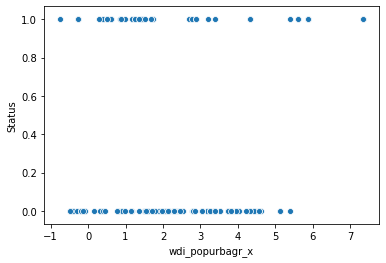

In [11]:
import seaborn as sns
sns.scatterplot(x=df1['wdi_popurbagr_x'],y=df1['Status'])

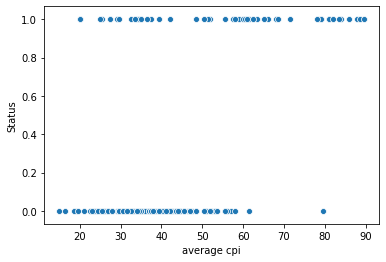

In [12]:
sns.scatterplot(x=df1['average cpi'],y=df1['Status'])

In [39]:
RFRegressor('Status',df1.drop(['Country 1','Country 2','C','Region_x','Subregion_x','Source_x','Year_x','Region_y','Subregion_y','Source_y','Year_y','Country Name_x','Country Name_y','Country','Border Status','version_x','version_y','cname_x','cname_y','ccodealp_x','ccodealp_y','viability','average cpi','Homicide Rate_x'],1))

Features sorted by their score:
[(0.0989, 'wdi_popurbagr_x'), (0.0655, 'wdi_gnicapatlcur_x'), (0.0589, 'undp_hdi_x'), (0.0325, 'who_homt_x'), (0.029, 'bi_fungiprot_x'), (0.0195, 'who_homm_x'), (0.0187, 'ffp_hr_y'), (0.0173, 'wdi_emp_x'), (0.0172, 'ihme_hle_0001f_x'), (0.0171, 'bi_mammals_x'), (0.0169, 'gii_gii_x'), (0.0154, 'eob_pt17_x'), (0.0152, 'average pfi'), (0.0149, 'wbgi_rle_x'), (0.0135, 'ffp_hf_y'), (0.0131, 'wdi_import_x'), (0.0126, 'wdi_lfprm_y'), (0.0124, 'average homicide'), (0.0123, 'fh_cl_x'), (0.0111, 'eob_eob17_x'), (0.0103, 'bi_total_y'), (0.0102, 'who_neomort_y'), (0.0102, 'wdi_gdpcapcur_x'), (0.0097, 'eob_qla_x'), (0.009, 'bci_bci_y'), (0.0088, 'wdi_lrmd_x'), (0.0086, 'ffp_dp_y'), (0.0085, 'who_mrf_y'), (0.0085, 'eob_pmi15_y'), (0.0078, 'wdi_lfpmilo15_y'), (0.0077, 'wdi_unempmilo_y'), (0.0075, 'wbgi_rqe_x'), (0.0061, 'wdi_mortnn_y'), (0.0061, 'eob_eob16_x'), (0.0061, 'Homicide County_x'), (0.006, 'fhp_score5_x'), (0.0058, 'average db'), (0.0057, 'wdi_emppryilo_y'), 

In [36]:
df1.shape

(185, 529)

In [19]:
def regression(y, df):
    df=df.dropna()
    X = df.drop([y], 1)
    y = df[y]
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model = statsmodels.regression.linear_model.OLS(y_train, X_train)
    model = model.fit()
    predictions = model.predict(X_test)
    # Plot the model
    plt.figure(figsize=(8,6))
    plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Predicted Values - $\hat{y}$")
    plt.ylabel("Actual Values - $y$")
    plt.show()
    print("MSE:", mean_squared_error(y_test, predictions))
    return model.summary()

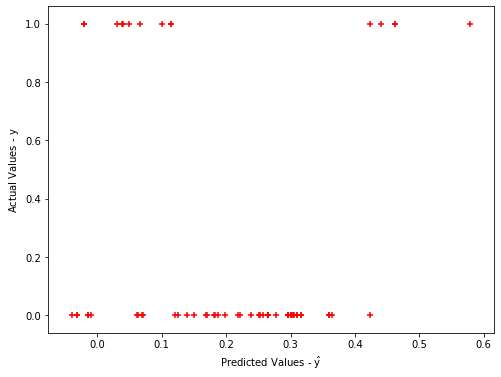

MSE: 0.21165892205720582


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.169
Model:                            OLS   Adj. R-squared (uncentered):              0.162
Method:                 Least Squares   F-statistic:                              24.75
Date:                Fri, 14 Feb 2020   Prob (F-statistic):                    2.17e-06
Time:                        14:51:58   Log-Likelihood:                         -85.876
No. Observations:                 123   AIC:                                      173.8
Df Residuals:                     122   BIC:                                      176.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
wdi_popurbagr_x     0.0788      0.016      4.975      0.000       0.047       0.110
==============================================================================
Omnibus:                       27.146   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.282
Skew:                           0.880   Prob(JB):                     3.94e-05
Kurtosis:                       2.072   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
regression('Status',df1[['wdi_popurbagr_x','Status']])

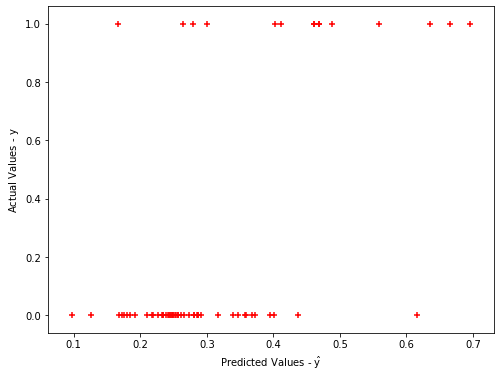

MSE: 0.13953820601205555


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.412
Model:                            OLS   Adj. R-squared (uncentered):              0.402
Method:                 Least Squares   F-statistic:                              42.34
Date:                Fri, 14 Feb 2020   Prob (F-statistic):                    1.15e-14
Time:                        14:52:03   Log-Likelihood:                         -64.609
No. Observations:                 123   AIC:                                      133.2
Df Residuals:                     121   BIC:                                      138.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
wdi_popurbagr_x    -0.0049      0.018     -0.276      0.783      -0.040       0.030
average cpi         0.0078      0.001      7.070      0.000       0.006       0.010
==============================================================================
Omnibus:                       20.006   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.734
Skew:                           1.041   Prob(JB):                     7.02e-06
Kurtosis:                       2.453   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
regression('Status',df1[['wdi_popurbagr_x','Status','average cpi']])

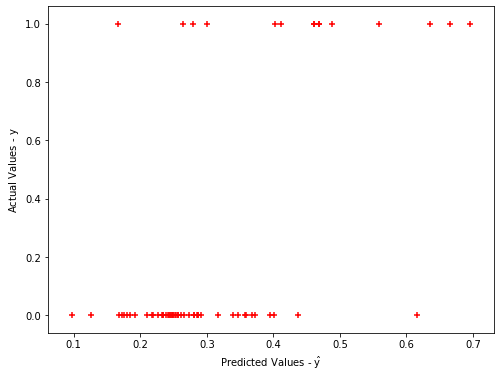

MSE: 0.13953820601205555


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Status   R-squared (uncentered):                   0.412
Model:                            OLS   Adj. R-squared (uncentered):              0.402
Method:                 Least Squares   F-statistic:                              42.34
Date:                Fri, 14 Feb 2020   Prob (F-statistic):                    1.15e-14
Time:                        14:52:14   Log-Likelihood:                         -64.609
No. Observations:                 123   AIC:                                      133.2
Df Residuals:                     121   BIC:                                      138.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
wdi_popurbagr_x    -0.0049      0.018     -0.276      0.783      -0.040       0.030
average cpi         0.0078      0.001      7.070      0.000       0.006       0.010
==============================================================================
Omnibus:                       20.006   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.734
Skew:                           1.041   Prob(JB):                     7.02e-06
Kurtosis:                       2.453   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
regression('Status',df1[['wdi_popurbagr_x','Status','average cpi']])

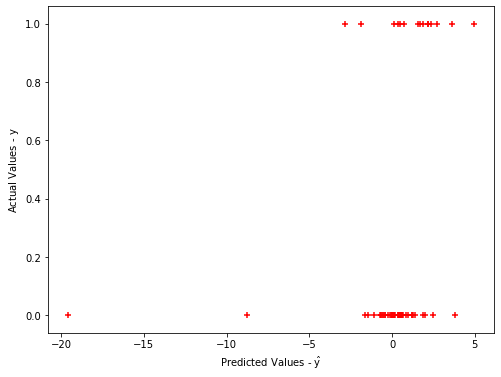

MSE: 9.081047937545604


In [28]:
result=regression('Status',df1.drop(['Country 1','Country 2','C','Region_x','Subregion_x','Source_x','Year_x','Region_y','Subregion_y','Source_y','Year_y','Country Name_x','Country Name_y','Country','Border Status','version_x','version_y','cname_x','cname_y','ccodealp_x','ccodealp_y','viability','average cpi'],1))